<a href="https://colab.research.google.com/github/hitesh-ag1/speech2text-analysis/blob/main/speech2text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1: Semantic Chunking of a YouTube Video** 📹

This part is divided into the following categories:
1. Environment Setup 💻
2. Downloading & Extracting Audio 🔊
3. Transcription 👂⌨️
4. Time-alignment ⌚
5. Semantic Chunking ⚡​
6. Future works 🧑‍⚖️

## Step 1: Environment Setup 💻

In [ ]:
!pip install pytube ffmpeg-python inflect yt-dlp openai-whisper pyannote.audio gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.5/873.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.1/760.1 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# 1. visit hf.co/pyannote/speaker-diarization and accept user conditions
# 2. visit hf.co/pyannote/segmentation and accept user conditions

HF_ACCESS_TOKEN = "" # add HuggingFace access token to use pyannote for speaker diarization

In [ ]:
import os
import yt_dlp
import ffmpeg
import librosa
import torchaudio
import torch
from IPython.display import Audio
import numpy as np
import soundfile as sf
from tqdm import tqdm
import torchaudio.functional as F
import matplotlib.pyplot as plt
from torchaudio.transforms import Resample
import string
import inflect
import re
import pandas as pd
import IPython
import whisper
import spacy
from pyannote.audio import Pipeline
from pyannote.audio.pipelines.utils.hook import ProgressHook
import itertools
import builtins
import json
import IPython

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
path = "task1/"
os.mkdir(path)

# Download pre-run results for t1
# t1_results/t1_output.json is the final output file generated
!gdown --id "14dhcbALAIaiDSQitarRefqUcvZUEqoL8" -O t1_results.zip
!unzip t1_results.zip
#path = "t1_results/"

## Step 2: Download Video & Extract Audio 🔊

In [ ]:
def download_youtube_video(url):
    ydl_opts = {
        'format': 'best',
        'outtmpl': '%(title)s.%(ext)s',
        'noplaylist': True,
    }

    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])

In [ ]:
download_youtube_video("https://www.youtube.com/watch?v=Sby1uJ_NFIY&ab_channel=moneycontrol")
os.rename("Sarvam AI Wants To Leverage AI In Health & Education Says Co Founder Vivek Raghavan With OpenHathi.mp4", "input.mp4")
ffmpeg.input("input.mp4").output(path+"input.wav").run()

[youtube] Extracting URL: https://www.youtube.com/watch?v=Sby1uJ_NFIY&ab_channel=moneycontrol
[youtube] Sby1uJ_NFIY: Downloading webpage
[youtube] Sby1uJ_NFIY: Downloading ios player API JSON
[youtube] Sby1uJ_NFIY: Downloading player dee49cfa
[youtube] Sby1uJ_NFIY: Downloading m3u8 information
[info] Sby1uJ_NFIY: Downloading 1 format(s): 22
[download] Destination: Sarvam AI Wants To Leverage AI In Health & Education Says Co Founder Vivek Raghavan With OpenHathi.mp4
[download] 100% of  358.34MiB in 00:00:15 at 22.93MiB/s  


(None, None)

In [ ]:
# path = "drive/MyDrive/sarvam_assignment/task1/"
input_file = path+"input.wav"
y, sr = librosa.load(input_file, sr=16000)

## Step 3: Transcription of audio 👂⌨️​

First, I divided the audio into several batches of varying length based on silence detection. This batching was necessary for my speech-time alignment model which ran out of memory if I ran it in one go.

Initially I used fixed-size batches (eg. 10s), however, this approach introduced transcription errors when there was an audio cut in the middle of a word.

In [ ]:
def detect_silence(audio_path, threshold_db=-30, min_silence_len=0.5, sampling_rate=16000):
    y, sr = librosa.load(audio_path, sr=sampling_rate)
    amplitude_envelope = librosa.feature.rms(y=y)[0]
    amplitude_db = librosa.amplitude_to_db(amplitude_envelope, ref=np.max)
    silent_frames = amplitude_db < threshold_db
    frame_times = librosa.frames_to_time(np.arange(len(amplitude_db)), sr=sr)
    silent_intervals = []
    start_time = None
    for i, silent in enumerate(silent_frames):
        if silent and start_time is None:
            start_time = frame_times[i]
        elif not silent and start_time is not None:
            end_time = frame_times[i]
            if end_time - start_time >= min_silence_len:
                silent_intervals.append((start_time, end_time))
            start_time = None

    if start_time is not None:
        end_time = frame_times[-1]
        if end_time - start_time >= min_silence_len:
            silent_intervals.append((start_time, end_time))

    return silent_intervals

silent_intervals = detect_silence(input_file, threshold_db=-30, min_silence_len=1)

Based on literature, SeamlessM4T and Whisper are state-of-the-art open source models which can be used for ASR. I initially experimented with "facebook/seamless-m4t-v2-large" and "openai/whisper-large-v3" using huggingface library. Based on visual experimentation, Whisper performed significantly better than SeamlessM4T based on WER. Additionally, whisper is a much smaller model as compared to seamless model series. Hence, I eventually decided to continue with Whisper.

Majority errors in transcription seemed to be around names or unclear audio (laughing, speakers overlap, diminished volume).

In order to reduce errors around names, I use the "initial_prompt" option available in whisper which is only available through the openai library, and not using huggingface. Additionally, I added padding to the start and end of the audio to reduce errors in those particular timeframes.

In [ ]:
# Fixed-size batching, Huggingface library, SeamlessM4T model
# Some experiments were done in Kaggle due to memory constraints in Colab

# model_name = "facebook/seamless-m4t-v2-large"
# model_name = "openai/whisper-large-v3"
# processor = AutoProcessor.from_pretrained(model_name)
# model = AutoModelForSpeechSeq2Seq.from_pretrained(model_name).to(device)
# chunk_size = 16000 * 10  # 10 seconds chunks
# padding = np.zeros(int(2*sr)) # 2 seconds padding
# padded_y = np.concatenate([padding, y, padding])
# num_chunks = (len(padded_y) // chunk_size) + 1

# transcriptions = []

# for i in tqdm(range(num_chunks)):
#     start_sample = i * chunk_size
#     end_sample = min((i + 1) * chunk_size, len(padded_y))
#     audio_chunk = padded_y[start_sample:end_sample]
#     audio_inputs = processor(audio_chunk, return_tensors="pt", sampling_rate=16000).to(device)
#     with torch.no_grad():
#         trans = model.generate(**audio_inputs).cpu().numpy()
#     transcription = processor.decode(trans[0].tolist(), skip_special_tokens=True)
#     transcriptions.append(transcription)


In [ ]:
split_points = [(x1+x2)/2 for x1, x2 in silent_intervals]
split_points.append(len(y)/sr)
transcriptions = []
model = whisper.load_model("large-v3").to(device)
prev = 0
for i in tqdm(range(len(split_points))):
    end = int(split_points[i]*sr)
    padding = np.zeros(int(1*sr))
    audio_chunk = y[prev:end]
    audio_chunk = np.concatenate([padding, audio_chunk, padding])
    prev = end
    audio_chunk = torch.tensor(audio_chunk).to(torch.float32)
    # transcription = model.transcribe(audio_chunk, language="en", initial_prompt="Vocabulary: Sarvam, OpenHathi, Bhavish Agarwal, Krutrim, Pratyush, Sarvam.ai, NVIDIA, OpenHathi, Bala, Llama from Meta, Sarvam AI, OpenAI, Sarvam.")
    transcription = model.transcribe(audio_chunk, language="en", initial_prompt="Vocabulary: Sarvam, OpenHathi, Bhavish Agarwal, Krutrim, Pratyush, Sarvam.ai, NVIDIA, OpenHathi, Bala, Llama 7 billion, Llama from Meta, Sarvam AI, OpenAI, Sarvam, Vivek Raghavan, NASA.")
    transcriptions.append(transcription['text'])

100%|██████████| 22/22 [07:39<00:00, 20.89s/it]


In [ ]:
# Below code is used to free up GPU memory

try:
    del model
except:
    pass

try:
    del waveform
except:
    pass

try:
    del audio_chunk
except:
    pass

import gc
gc.collect()
torch.cuda.empty_cache()
del gc

## Step 4: Time Align Transcript with Audio ⌚​

In order to time align transcript with audio, I use Forced Alignment which aligns audio to transcript at a phoneme level. However, before I proceed I need to normalize my transcript by removing punctuations and converting numbers to words to make it input-ready to FA.

In [ ]:
p = inflect.engine()
def convert_numbers_to_words(text):
    pattern = re.compile(r'(?<!\d)(\d+)(?!\d)')
    def replace_number(match):
        number = match.group()
        return p.number_to_words(number)
    return pattern.sub(replace_number, text)

proc_t = []
for t in transcriptions:
    t2 = t.lower()
    common_replacements = {
        '–': '',
        "…": ""
    }
    for key, val in common_replacements.items():
        t2 = t2.replace(key, val)

    punctuation = string.punctuation.replace("'", "")
    translator = str.maketrans(punctuation, ' ' * len(punctuation), "'")
    t2 = convert_numbers_to_words(t2).translate(translator).lower().strip().split()
    proc_t.append(t2)

I used the Forced Aligner (FA) from the paper "Scaling Speech Technology to 1,000+ Languages" named MMS_FA which stands for "Massively Multilingual Speech - Forced Aligner." Dictionary is used to tokenize the transcript so that it can be aligned with the output of the model. MMS_FA was used as it is a state-of-the-art aligner which is generalizable to multiple languages. Stepwise process for FA is highlighted below:



1.   Generate emmissions - Utilise an acoustic model to generate framewise probability distribution over tokens.
2.   Tokenize transcript
3.   Compute alignments:
  - Frame level
  - Token level
  - Word level



In [ ]:
bundle = torchaudio.pipelines.MMS_FA
model = bundle.get_model(with_star=False).to(device)
DICTIONARY = bundle.get_dict(star=None)

Downloading: "https://dl.fbaipublicfiles.com/mms/torchaudio/ctc_alignment_mling_uroman/model.pt" to /root/.cache/torch/hub/checkpoints/model.pt
100%|██████████| 1.18G/1.18G [00:10<00:00, 122MB/s]


In [ ]:
#Returns timestamps of tokens and assosciated scores
def align(emission, tokens):
    targets = torch.tensor([tokens], dtype=torch.int32, device=device)
    alignments, scores = F.forced_align(emission, targets, blank=0)

    alignments, scores = alignments[0], scores[0]
    scores = scores.exp()
    return alignments, scores

#Converts token-level alignment to word-level alignment
def unflatten(list_, lengths):
    assert len(list_) == sum(lengths)
    i = 0
    ret = []
    for l in lengths:
        ret.append(list_[i : i + l])
        i += l
    return ret

In [ ]:
prev = 0
prevSize = 0
aligned_speech = []
for i in tqdm(range(len(split_points))):
    end = int(split_points[i]*sr)
    audio_chunk = y[prev:end]
    prev = end
    audio_chunk = torch.tensor([audio_chunk]).to(torch.float32).to(device)
    with torch.inference_mode():
        #generating emissions
        emission, _ = model(audio_chunk)

    #tokenising transcript
    tokenized_transcript = [DICTIONARY[c.lower()] for word in proc_t[i] for c in word]

    #generating frame level alignments
    aligned_tokens, alignment_scores = align(emission, tokenized_transcript)

    #generating token level alignments
    token_spans = F.merge_tokens(aligned_tokens, alignment_scores)

    #generating word level alignments
    word_spans = unflatten(token_spans, [len(word) for word in proc_t[i]])
    temp = []
    for el in range(len(proc_t[i])):
        ratio = audio_chunk.size(1) / emission.size(1)
        x0 = int(ratio * word_spans[el][0].start) + prevSize
        x1 = int(ratio * word_spans[el][-1].end) + prevSize
        sc = []

        #calculating average word level alignment score
        for score in range(len(word_spans[el])):
            sc.append(word_spans[el][score].score)
        sc = np.sum(sc)/len(sc)

        temp.append({
            'word': proc_t[i][el],
            'start':x0,
            'stop':x1,
            'score':sc
        })
    aligned_speech.append(temp)
    prevSize += audio_chunk.size(1)

100%|██████████| 22/22 [00:51<00:00,  2.36s/it]


In [ ]:
# free up GPU

try:
    del model
except:
    pass

try:
    del waveform
except:
    pass

try:
    del audio_chunk
except:
    pass

import gc
gc.collect()
torch.cuda.empty_cache()
del gc

Since the task's focus metric is precision, I optimized for it by removing words with low alignment scores (<0.1). This threshold can be finetuned based on WER using ground truth labels.

In [ ]:
mod_align_sp = []
for el in aligned_speech:
    temp_as = pd.DataFrame(el)
    temp_as.loc[temp_as[temp_as['score']<0.1].index, 'word'] = '<REMOVED>'
    mod_align_sp.append(temp_as.to_dict('records'))

## Step 5: Semantic chunking ⚡​

Text-based:
1. Split by sentences. Use "spacy/en_core_web_sm" to detect sentences and split at every new sentence.
2. Split on conjunctions. Manual regex-based split whenever conjunctions like "and", "or", "so", etc. are detected.

Voice-based:
1. Split on silence (>0.5s). Already implemented.
2. Split by speaker. Ideally, a single segment should have only one speaker and should be split as soon as next speaker starts speaking. This is implemented using pyannotate's speaker diarizer.

### Sentence-based splitting

In [ ]:
sentences = []
nlp = spacy.load('en_core_web_sm')
for i in transcriptions:
    temp = (list(nlp(i).sents))
    temp = [str(t).strip() for t in temp if len(str(t).strip())>0]
    sentences.append(temp)

In [ ]:
def find_word_indices(sent, word):
    sent_words = sent.split()
    word_words = word.split()

    sent_length = len(sent_words)

    for i in range(len(word_words) - sent_length + 1):
        if word_words[i:i + sent_length] == sent_words:
            return i, i + sent_length - 1

In [ ]:
sentence_align = []
for sp in range(len(mod_align_sp)):
    df = pd.DataFrame(mod_align_sp[sp])
    words = ' '.join(list(df['word']))
    punctuation = string.punctuation.replace("'", "")
    translator = str.maketrans(punctuation, ' ' * len(punctuation), "'")
    for i in range(len(sentences[sp])):
        sent = ' '.join(convert_numbers_to_words(str(sentences[sp][i])).translate(translator).lower().strip().split())
        sent2 = re.escape(sent)
        sent2 = rf'\b{sent}\b'

        if bool(re.search(sent2, words)):
            start_index, end_index = find_word_indices(sent, words)
            li = list((df[start_index:end_index+1]).to_records())
            sentence_align.append([str(sentences[sp][i]), li[0]['start']/sr, li[-1]['stop']/sr, li])

sentence_align = pd.DataFrame(sentence_align, columns=['sentence', 'start', 'stop', 'ts'])
sentence_align = sentence_align.drop(list(sentence_align[sentence_align.duplicated('ts')].index))
sentence_align.index = np.arange(len(sentence_align))
sentence_align.to_csv(path+"sentence_alignment.csv")

Sentence alignment is saved in a CSV file here.

### Speaker Diarization

**Accuracy of speaker diarization is very poor**. In the future, I would finetune the diarization model using the [diarizers](https://github.com/huggingface/diarizers) library to improve the accuracy.

In [ ]:
# Since Speaker diarization is extremely slow and consumes limited colab GPU time \
# I only ran it once and saved the results

pipeline = Pipeline.from_pretrained(
    "pyannote/speaker-diarization-3.1",
    use_auth_token=HF_ACCESS_TOKEN) # remember to use your HF access token & agree to pyannotate's T&C
pipeline.to(torch.device("cuda"))

with ProgressHook() as hook:
    diarization = pipeline(input_file, hook=hook)

with open("audio_diar.rttm", "w") as rttm:
    diarization.write_rttm(rttm)

diar_labels = []
for turn, _, speaker in diarization.itertracks(yield_label=True):
    diar_labels.append([speaker, turn.start, turn.end])

def merge_diarization(diarization_list):
    if not diarization_list:
        return []

    merged_list = [diarization_list[0]]

    for current in diarization_list[1:]:
        previous = merged_list[-1]
        if current[0] == previous[0]:
            merged_list[-1] = [previous[0], previous[1], current[2]]
        else:
            merged_list.append(current)

    return merged_list

diar_labels2 = merge_diarization(diar_labels)
diar_labels3 = []
for current in diar_labels2:
    if current[2]-current[1]>2:
        diar_labels3.append(current)
pd.DataFrame(diar_labels3).to_csv(path+"speaker_alignment.csv")

Result of speaker alignment is saved in a CSV file.

Merge speaker diarization & sentence split

**Note: Since there are different variations of whisper results in each run & I only ran speaker diarization once, I am loading the results from that particular experiment so that there are no discrepancies between the two outputs.**

In [ ]:
path = "t1_results/"
df1 = pd.read_csv(path+"speaker_alignment.csv")
df2 = pd.read_csv(path+"sentence_alignment.csv")

# df1 = pd.DataFrame(diar_labels3)
# df2 = sentence_align

In [ ]:
df1.columns = ['del', 'speaker', 'start', 'end']
df2.columns = ['del', 'sentence', 'start', 'end', 'ts']
df2['ts'] = df2['ts'].apply(eval)
df1 = df1.drop('del', axis=1)
df2 = df2.drop('del', axis=1)

df2['mean'] = (df2['start']+df2['end'])/2
speaker = np.full(len(df2), '', dtype=object)
for i, row in df1.iterrows():
    start, stop = row['start'], row['end']
    speaker[df2[(df2['mean']<stop) & (df2['mean']>start)].index] = row['speaker']
df2['speaker'] = speaker
df2 = df2.drop('mean', axis=1)
df2['duration'] = df2['end'] - df2['start']

for i, row in df2[df2['speaker']==''].iterrows():
  start, stop = row['start'], row['end']
  try:
    speaker = df1[((df1['start']<start) & (start<df1['end'])) | ((df1['end']>stop) & (stop>df1['start']))].iloc[-1]['speaker']
    df2.loc[i,'speaker'] = speaker
  except:
    continue

df2['speaker'] = df2['speaker'].replace('', pd.NA).ffill()
df2 = df2.sort_values(by='start')
df2.index = np.arange(len(df2))

In [ ]:
p = inflect.engine()
def convert_numbers_to_words(text):
    pattern = re.compile(r'(?<!\d)(\d+)(?!\d)')
    def replace_number(match):
        number = match.group()
        return p.number_to_words(number)
    return pattern.sub(replace_number, text)

punctuation = string.punctuation.replace("'", "")
translator = str.maketrans(punctuation, ' ' * len(punctuation), "'")

### Split by conjunction

In [ ]:
def split_sentence_by_connector_and_time(row, max_duration=15):
      split_flag = False
      if row['duration']>15:
        split_flag = True

      connectors = [
    "and", "or", "but", "nor", "for", "yet", "so", "because", "although", "if", "since", "unless", "while",
    "however", "therefore", "moreover", "nevertheless", "furthermore", "consequently"
      ]

      sentences = []
      sentences2 = []
      timestamps = []
      current_ts = []
      current_sentence = []
      current_sentence2 = []
      duration = []
      speaker=[]
      start = []
      end = []
      for i in range(len(row['ts'])):
          curr_speaker = row['speaker']
          word = row['ts'][i][1]
          try:
            word_sentence = row['sentence'].split()[i]
          except:
            word_sentence = ""
          if (word in connectors and split_flag and i>0):
              sentences.append(' '.join(current_sentence))
              timestamps.append(current_ts)
              start.append(current_ts[0][2]/16000)
              end.append(current_ts[-1][3]/16000)
              duration.append(end[-1]-start[-1])
              speaker.append(row['speaker'])
              current_sentence = [word]
              current_ts = [row['ts'][i]]
          else:
              current_sentence.append(word)
              current_ts.append(row['ts'][i])
              # duration.append((current_ts[-1][3]-current_ts[0][2])/16000)
          if (word_sentence.lower() in connectors and i>0 and split_flag):
              sentences2.append(' '.join(current_sentence2))
              current_sentence2 = [word_sentence]
          else:
              current_sentence2.append(word_sentence)

      if current_sentence:
          sentences.append(' '.join(current_sentence))
          timestamps.append(current_ts)
          start.append(current_ts[0][2]/16000)
          end.append(current_ts[-1][3]/16000)
          duration.append(end[-1]-start[-1])
          speaker.append(curr_speaker)

      current_sentence2.append(' '.join(row['sentence'].split()[i+1:]))
      if current_sentence2:
          sentences2.append(' '.join(current_sentence2).strip())

      return [sentences, sentences2, timestamps, duration, speaker, start, end]

new_df = []
for i, row in df2.iterrows():
    proc = split_sentence_by_connector_and_time(row)
    for j in range(len(proc[0])):
      new_df.append([proc[0][j], proc[1][j], proc[2][j], proc[3][j], proc[4][j], proc[5][j], proc[6][j]])
new_df = pd.DataFrame(new_df, columns=['sentence', 'sentences2' ,'ts', 'duration', 'speaker', 'start', 'end'])

In [ ]:
df = new_df.copy()

merged_rows = []
current_row = df.iloc[0]

for i in range(1, len(df)):
    next_row = df.iloc[i]
    if current_row['speaker'] == next_row['speaker'] and (next_row['end'] - current_row['start']) < 15 and (current_row['end']==next_row['start']):
        current_row['sentence'] += " " + next_row['sentence']
        current_row['sentences2'] += " " + next_row['sentences2']
        current_row['end'] = next_row['end']
        current_row['duration'] = next_row['end'] - current_row['start']
        current_row['ts'].extend(next_row['ts'])
    else:
        merged_rows.append(current_row)
        current_row = next_row

merged_rows.append(current_row)
merged_df = pd.DataFrame(merged_rows)
merged_df = merged_df.drop_duplicates('sentence')
merged_df = merged_df[merged_df['duration']>1]
merged_df.index = np.arange(len(merged_df))

In [ ]:
chunks = [
    {
        "chunk_id": i,
        "chunk_length": round(row["duration"], 1),
        "text": row["sentences2"],
        "start_time": round(row["start"], 1),
        "end_time": round(row["end"], 1)
    }
    for i, row in merged_df.iterrows()
]

In [ ]:
with open("t1_output.json", "w") as file:
    json.dump(chunks, file, indent=4)

In [ ]:
chunks

[{'chunk_id': 0,
  'chunk_length': 2.0,
  'text': 'Congratulations to you Mr. Raghavan for that.',
  'start_time': 0.1,
  'end_time': 2.1},
 {'chunk_id': 1,
  'chunk_length': 1.1,
  'text': 'Thank you so much for joining us.',
  'start_time': 2.3,
  'end_time': 3.4},
 {'chunk_id': 2,
  'chunk_length': 1.4,
  'text': 'Hi everybody, how are you?',
  'start_time': 8.7,
  'end_time': 10.1},
 {'chunk_id': 3,
  'chunk_length': 1.6,
  'text': 'Okay, I am not hearing this at all.',
  'start_time': 11.9,
  'end_time': 13.5},
 {'chunk_id': 4,
  'chunk_length': 3.0,
  'text': "It's like a post lunch energy downer or something.",
  'start_time': 14.0,
  'end_time': 17.0},
 {'chunk_id': 5,
  'chunk_length': 4.9,
  'text': 'All right, you better be because we have a superstar guest here.',
  'start_time': 22.0,
  'end_time': 26.9},
 {'chunk_id': 6,
  'chunk_length': 3.8,
  'text': "You heard the $41 million and I didn't hear honestly anything she said after that.",
  'start_time': 27.8,
  'end_time'

## Step 6: Future works 🧑‍⚖️

The code written above is very task specific and I would focus on improving generalizability of the code like adding multilingual support and making it scalable for even longer videos. The current output might have small chunks as well which maybe less than 3-4s. When creating a dataset for ASR training, it is generally advisable to have chunks >5s. If that was the intentended use of the chunks, I would focus on min. time of chunks as well and merging of multiple chunks according to time.

Additionally, there was no metric calculation and score optimization on WER. I would transcribe the segments using a paid ASR solution like Azure and compare those as ground truth with my transcription. This would help optimize the above code for better precision. Optimization would be done on prompt to whisper, word score alignment threshold, choice of open-source models like Whisper and MMS_FA.

# Part 2: Exploratory Data Analysis of New Testament Audio and Text 📖

This task's solution is divided into the following categories:
1. Environment Setup 💻
2. Web scraping 🕸️
3. Data Preparation 🤗
4. Exploratory Data Analysis 🛳️:
  - 🔊⌨️ Speech-Text Alignment
  - 🔊⌨️ Word-Level Speech-Text Analysis
  - 🔊 Audio-Based Anomaly Detection
  - 🔊 Audio Duration Analysis
  - 🔊 Audio Quality Analysis
  - ⌨️ Word-Level Text Analysis
  - ⌨️ Text Bias Analysis
  - ⌨️ Phoneme-level Analysis
5. Conclusion 📄

## Step 1: Environment Setup 💻

In [ ]:
!pip install selenium google-colab-selenium ffmpeg-python Unidecode uroman-python huggingface_hub fastdtw phonemizer fastdtw datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.7/467.7 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 M

In [ ]:
! git clone https://github.com/isi-nlp/uroman.git

Cloning into 'uroman'...
remote: Enumerating objects: 299, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 299 (delta 76), reused 88 (delta 49), pack-reused 168
Receiving objects: 100% (299/299), 5.26 MiB | 18.39 MiB/s, done.
Resolving deltas: 100% (144/144), done.


In [ ]:
!apt-get install -y festival espeak-ng mbrola

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  alsa-utils espeak-ng-data festlex-cmu festlex-poslex festvox-kallpc16k libatopology2
  libespeak-ng1 libestools2.5 libfftw3-single3 libpcaudio0 libsonic0 sgml-base
Suggested packages:
  dialog pidgin-festival festival-freebsoft-utils libfftw3-bin libfftw3-dev mbrola-voice cicero
  sgml-base-doc
The following NEW packages will be installed:
  alsa-utils espeak-ng espeak-ng-data festival festlex-cmu festlex-poslex festvox-kallpc16k
  libatopology2 libespeak-ng1 libestools2.5 libfftw3-single3 libpcaudio0 libsonic0 mbrola sgml-base
0 upgraded, 15 newly installed, 0 to remove and 45 not upgraded.
Need to get 13.2 MB of archives.
After this operation, 39.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 sgml-base all 1.30 [12.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libato

In [ ]:
from tqdm import tqdm
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
import requests
import google_colab_selenium as gs
from bs4 import BeautifulSoup
import time
import os
import ffmpeg
import librosa
import torchaudio
import torch
from IPython.display import Audio
import numpy as np
import soundfile as sf
from tqdm import tqdm
import torchaudio.functional as F
import matplotlib.pyplot as plt
import string
import re
import pandas as pd
import IPython
import spacy
import itertools
import builtins
import json
import IPython
import unicodedata
from unidecode import unidecode
import tempfile
import datasets
from datasets import Dataset, Audio, load_dataset
from fastdtw import fastdtw
from scipy.fftpack import fft
from sklearn.decomposition import PCA
from torchaudio import transforms
import nltk
from nltk import ngrams
from nltk.tokenize import word_tokenize
from collections import Counter
from huggingface_hub import login
from phonemizer import phonemize
from phonemizer.backend import EspeakBackend
from phonemizer.separator import Separator
from collections import Counter
from selenium.webdriver.common.by import By
import seaborn as sns
from datasets import DatasetDict
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!gdown --id "1a78LH4cfSw1XPzBT_XVEgzFE9vg97b5T" -O bible/punctuations.lst

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1a78LH4cfSw1XPzBT_XVEgzFE9vg97b5T
To: /content/bible/punctuations.lst
100% 6.07k/6.07k [00:00<00:00, 3.02MB/s]


In [ ]:
# from huggingface_hub import login
# HF_ACCESS_TOKEN = "" # add your HF token
# login(HF_ACCESS_TOKEN)

## Step 2: Web scraping 🕸️

In the below web scraping script, I have added appropriate error handling techniques to make the below script scalable. Some important elements:
- Wait for 5s before sending next request.
- Use WebDriverWait so that the script waits for the website to completely load until the described element appears.
- If there is any error, it waits for 20s and retries with appropriate logging
- If the extracted text is less than 2 characters, wait for 20s and retry with logging.
- If size of audio file is too small, retry after 20s with logging.

In [ ]:
def download_text_audio(count, book, chapter):
  url = 'https://live.bible.is/bible/HINOHC/'+book+"/"+chapter
  driver.get(url)
  try:

    video_tag = WebDriverWait(driver, 25).until(
          EC.presence_of_element_located((By.CSS_SELECTOR, 'video.audio-player'))
    )
    text_tag = WebDriverWait(driver, 25).until(
          EC.presence_of_element_located((By.CSS_SELECTOR, 'div.chapter.justify'))
    )
  except:
    print("Something is wrong. Retrying chapter "+ count+" after 20s")
    time.sleep(20)
    return download_text_audio(count, book, chapter)

  # video_tag = driver.presence_of_element_located((By.CSS_SELECTOR, 'video.audio-player'))
  # text_tag = driver.find_element((By.CSS_SELECTOR, 'div.chapter.justify'))
  chapter_html = text_tag.get_attribute('outerHTML')
  soup = BeautifulSoup(chapter_html, 'html.parser')

  verses = soup.find_all('span', class_='align-left')
  verse_texts = [verse.get_text(separator=" ").split('\xa0')[2].strip() for verse in verses]
  if len(verse_texts)<2:
    print("Verse too small. Retrying chapter "+ count+" after 20s")
    time.sleep(20)
    return download_text_audio(count, book, chapter)

  audio_url = video_tag.get_attribute('src')
  # print(f'{count}. Audio URL: {audio_url}')

  audio_response = requests.get(audio_url)
  audio_file_path = base_dir+'audio/'+'audio_'+count+'.mp3'
  with open(audio_file_path, 'wb') as file:
      file.write(audio_response.content)
  if (os.path.getsize(audio_file_path) / 1024) < 500:
    print("Audio file too small. Retrying chapter "+ count+" after 20s")
    time.sleep(20)
    return download_text_audio(count, book, chapter)

  return verse_texts


In [ ]:
driver = gs.Chrome()
url = 'https://live.bible.is/bible/HINOHC/GEN/1'
driver.get(url)
driver.implicitly_wait(10)

script_tag = driver.find_element(By.XPATH, '//script[@id="__NEXT_DATA__"]')
json_data = script_tag.get_attribute('innerHTML')

data = json.loads(json_data)
chapter_text_list = data["props"]["pageProps"]["chapterText"]
chapters = {}
for el in data["props"]["pageProps"]["books"]:
  if el['testament']=='NT':
    chapters[el['testament_order']] = [el['book_id'], el['chapters']]

driver.quit()

<IPython.core.display.Javascript object>

In [ ]:
print(chapters[1])

['MAT', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]]


In [ ]:
base_dir = "bible/"
audio_dir = base_dir+"audio/"
txt_dir = base_dir+"text/"
os.mkdir(base_dir)
os.mkdir(audio_dir)
os.mkdir(txt_dir)

In [ ]:
# Ran this function only once. The printed output is just for few initial chapters and then was interrupted.
# However, dataset in HF contains all chapters

base_url = "https://live.bible.is/bible/HINOHC/"
chapter=1
driver = gs.Chrome()
ch_texts = {}
for key, val in chapters.items():
  i = str(chapters[key][0])
  for j in chapters[key][1]:
    ch_texts[chapter] = download_text_audio(str(chapter), i, str(j))
    print("Downloaded "+str(chapter)+"/260")
    chapter+=1
    time.sleep(5)
driver.quit()

<IPython.core.display.Javascript object>

Downloaded 1/260
Downloaded 2/260
Downloaded 3/260
Downloaded 4/260
Downloaded 5/260
Downloaded 6/260
Downloaded 7/260
Downloaded 8/260
Downloaded 9/260
Downloaded 10/260
Downloaded 11/260
Downloaded 12/260
Downloaded 13/260
Downloaded 14/260
Downloaded 15/260
Downloaded 16/260
Downloaded 17/260
Downloaded 18/260
Downloaded 19/260
Downloaded 20/260
Something is wrong. Retrying chapter 21 after 20s
Downloaded 21/260
Something is wrong. Retrying chapter 22 after 20s
Downloaded 22/260
Downloaded 23/260


KeyboardInterrupt: 

In [ ]:
for key, val in ch_texts.items():
  with open(base_dir+"text"+"/"+"text_"+str(key)+".txt", "w") as f:
    for line in val:
      f.write(line + '\n')

## Step 3: Data Preparation 🤗

Add dataset to HF Hub for easy and efficient retrieval

In [ ]:
base_path = base_dir
audio_path = audio_dir
text_path = txt_dir

records = []

audio_files = sorted(os.listdir(audio_path))
text_files = sorted(os.listdir(text_path))

for audio_file, text_file in zip(audio_files, text_files):
    if audio_file.endswith(".mp3") and text_file.endswith(".txt"):
        audio_file_path = os.path.join(audio_path, audio_file)
        text_file_path = os.path.join(text_path, text_file)

        with open(text_file_path, "r") as f:
            text = f.read().strip()

        records.append({"audio": audio_file_path, "text": text})


dataset = Dataset.from_dict({"audio": [e["audio"] for e in records], "text": [e["text"] for e in records]})
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
dataset_dict = DatasetDict({"dataset": dataset})
dataset_dict.save_to_disk("/bible_hf_dataset")
# dataset_dict.push_to_hub("hiteshagarwal/bible_stt") # Uncomment if want to push data

## Step 4: Exploratory Data Analysis 🛳️

In [ ]:
dataset = load_dataset("hiteshagarwal/bible_stt")
dataset = dataset['dataset']
device = "cuda" if torch.cuda.is_available() else "cpu"
path = "bible/"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



Generating dataset split:   0%|          | 0/260 [00:00<?, ? examples/s]

### Step 4.1: Speech-Text Alignment

I will follow a similar alignment approach as Task 1 with difference in:
1. Normalization - Hindi specific normalization techniques to remove punctuations.
2. Uromanization - Converts Devanagri to Latin which is interpretable by MMS_FA model. Currently, I have used uromanization for transliteration due to best accuracy as compared to other transliteration models. However, one major drawback with uromanization is that it always converts Bindu matra to letter 'm' which introduces error.
3. Add star (*) token in the beginning of every text for each audio file in case the paired text does not cover the beginning of the audio which is the case in most audio files. Enable star token in MMS_FA model.

#### Helper Functions for normalization & uromanization

In [ ]:
colon = ":"
comma = ","
exclamation_mark = "!"
period = re.escape(".")
question_mark = re.escape("?")
semicolon = ";"

left_curly_bracket = "{"
right_curly_bracket = "}"
quotation_mark = '"'

basic_punc = (
    period
    + question_mark
    + comma
    + colon
    + exclamation_mark
    + left_curly_bracket
    + right_curly_bracket
)

# General punc unicode block (0x2000-0x206F)
zero_width_space = r"\u200B"
zero_width_nonjoiner = r"\u200C"
left_to_right_mark = r"\u200E"
right_to_left_mark = r"\u200F"
left_to_right_embedding = r"\u202A"
pop_directional_formatting = r"\u202C"

# Here are some commonly ill-typed versions of apostrophe
right_single_quotation_mark = r"\u2019"
left_single_quotation_mark = r"\u2018"

# Language specific definitions
# Hindi
hindi_danda = u"\u0964"

lesser_than_symbol = r"&lt;"
greater_than_symbol = r"&gt;"

lesser_than_sign = r"\u003c"
greater_than_sign = r"\u003e"

nbsp_written_form = r"&nbsp"

# Quotation marks
left_double_quotes = r"\u201c"
right_double_quotes = r"\u201d"
left_double_angle = r"\u00ab"
right_double_angle = r"\u00bb"
left_single_angle = r"\u2039"
right_single_angle = r"\u203a"
low_double_quotes = r"\u201e"
low_single_quotes = r"\u201a"
high_double_quotes = r"\u201f"
high_single_quotes = r"\u201b"

all_punct_quotes = (
    left_double_quotes
    + right_double_quotes
    + left_double_angle
    + right_double_angle
    + left_single_angle
    + right_single_angle
    + low_double_quotes
    + low_single_quotes
    + high_double_quotes
    + high_single_quotes
    + right_single_quotation_mark
    + left_single_quotation_mark
)
mapping_quotes = (
    "["
    + high_single_quotes
    + right_single_quotation_mark
    + left_single_quotation_mark
    + "]"
)


# Digits

english_digits = r"\u0030-\u0039"
bengali_digits = r"\u09e6-\u09ef"
khmer_digits = r"\u17e0-\u17e9"
devanagari_digits = r"\u0966-\u096f"
oriya_digits = r"\u0b66-\u0b6f"
extended_arabic_indic_digits = r"\u06f0-\u06f9"
kayah_li_digits = r"\ua900-\ua909"
fullwidth_digits = r"\uff10-\uff19"
malayam_digits = r"\u0d66-\u0d6f"
myanmar_digits = r"\u1040-\u1049"
roman_numeral = r"\u2170-\u2179"
nominal_digit_shapes = r"\u206f"

# Load punctuations from MMS-lab data
with open(f"{path}/punctuations.lst", "r") as punc_f:
    punc_list = punc_f.readlines()

punct_pattern = r""
for punc in punc_list:
    # the first character in the tab separated line is the punc to be removed
    punct_pattern += re.escape(punc.split("\t")[0])

shared_digits = (
    english_digits
    + bengali_digits
    + khmer_digits
    + devanagari_digits
    + oriya_digits
    + extended_arabic_indic_digits
    + kayah_li_digits
    + fullwidth_digits
    + malayam_digits
    + myanmar_digits
    + roman_numeral
    + nominal_digit_shapes
)

shared_punc_list = (
    basic_punc
    + all_punct_quotes
    + greater_than_sign
    + lesser_than_sign
    + semicolon
    + hindi_danda
    + quotation_mark
    + punct_pattern

)

shared_mappping = {
    lesser_than_symbol: "",
    greater_than_symbol: "",
    nbsp_written_form: "",
    r"(\S+)" + mapping_quotes + r"(\S+)": r"\1'\2",
}

shared_deletion_list = (
    left_to_right_mark
    + zero_width_nonjoiner
    + zero_width_space
    + pop_directional_formatting
    + right_to_left_mark
    + left_to_right_embedding
)

norm_config = {
    "*": {
        "lower_case": True,
        "punc_set": shared_punc_list,
        "del_set": shared_deletion_list,
        "mapping": shared_mappping,
        "digit_set": shared_digits,
        "unicode_norm": "NFKC",
        "rm_diacritics" : False,
    }
}


def text_normalize(text, iso_code="hi", lower_case=True, remove_numbers=True, remove_brackets=True):

    config = norm_config.get(iso_code, norm_config["*"])

    for field in ["lower_case", "punc_set","del_set", "mapping", "digit_set", "unicode_norm"]:
        if field not in config:
            config[field] = norm_config["*"][field]


    text = unicodedata.normalize(config["unicode_norm"], text)

    # Convert to lower case

    if config["lower_case"] and lower_case:
        text = text.lower()

    # brackets

    # always text inside brackets with numbers in them. Usually corresponds to "(Sam 23:17)"
    text = re.sub(r"\([^\)]*\d[^\)]*\)", " ", text)
    if remove_brackets:
        text = re.sub(r"\([^\)]*\)", " ", text)

    # Apply mappings

    for old, new in config["mapping"].items():
        text = re.sub(old, new, text)

    # Replace punctutations with space

    punct_pattern = r"[" + config["punc_set"]

    punct_pattern += "]"

    normalized_text = re.sub(punct_pattern, " ", text)

    # remove characters in delete list

    delete_patten = r"[" + config["del_set"] + "]"

    normalized_text = re.sub(delete_patten, "", normalized_text)

    # Remove words containing only digits
    # We check for 3 cases  a)text starts with a number b) a number is present somewhere in the middle of the text c) the text ends with a number
    # For each case we use lookaround regex pattern to see if the digit pattern in preceded and followed by whitespaces, only then we replace the numbers with space
    # The lookaround enables overlapping pattern matches to be replaced

    if remove_numbers:

        digits_pattern = "[" + config["digit_set"]

        digits_pattern += "]+"

        complete_digit_pattern = (
            r"^"
            + digits_pattern
            + "(?=\s)|(?<=\s)"
            + digits_pattern
            + "(?=\s)|(?<=\s)"
            + digits_pattern
            + "$"
        )

        normalized_text = re.sub(complete_digit_pattern, " ", normalized_text)

    if config["rm_diacritics"]:
        normalized_text = unidecode(normalized_text)

    normalized_text = re.sub(r"—", " ", normalized_text).strip()
    normalized_text = re.sub(r"-", " ", normalized_text).strip()
    # Remove extra spaces
    normalized_text = re.sub(r"\s+", " ", normalized_text).strip()

    return normalized_text

def normalize_uroman(text):
    text = text.lower()
    text = re.sub("([^a-z' ])", " ", text)
    text = re.sub(' +', ' ', text)
    return text.strip()


def get_uroman_tokens(norm_transcripts, uroman_root_dir, iso = None):
    tf = tempfile.NamedTemporaryFile()
    tf2 = tempfile.NamedTemporaryFile()
    with open(tf.name, "w") as f:
        for t in norm_transcripts:
            f.write(t + "\n")

    assert os.path.exists(f"{uroman_root_dir}/uroman.pl"), "uroman not found"
    cmd = f"perl {uroman_root_dir}/uroman.pl"
    cmd +=  f" < {tf.name} > {tf2.name}"
    os.system(cmd)
    outtexts = []
    with open(tf2.name) as f:
        for line in f:
            line = " ".join(line.strip())
            line =  re.sub(r"\s+", " ", line).strip()
            outtexts.append(line)
    assert len(outtexts) == len(norm_transcripts)
    uromans = []
    for ot in outtexts:
        uromans.append(normalize_uroman(ot))
    return uromans



In [ ]:
#Returns timestamps of tokens and assosciated scores
def align(emission, tokens):
    targets = torch.tensor([tokens], dtype=torch.int32, device=device)
    alignments, scores = F.forced_align(emission, targets, blank=0)

    alignments, scores = alignments[0], scores[0]
    scores = scores.exp()
    return alignments, scores

#Converts token-level alignment to word-level alignment
def unflatten(list_, lengths):
    assert len(list_) == sum(lengths)
    i = 0
    ret = []
    for l in lengths:
        ret.append(list_[i : i + l])
        i += l
    return ret

def getAlignment(dp):
    y, sr = dp['audio']['array'], dp['audio']['sampling_rate']
    transcripts = dp['text'].split("\n")

    norm_transcripts = [text_normalize(line.strip(), "hi") for line in transcripts]
    norm_transcripts2 = []
    for t in norm_transcripts:
        norm_transcripts2.append(t.split())

    norm_transcripts2 = [word for sent in norm_transcripts2 for word in sent]
    token_trans = get_uroman_tokens(norm_transcripts2, "uroman/bin/", "hi")
    norm_transcripts2 = ["***"] + norm_transcripts2
    token_trans = ["***"] + ["".join(word.split()) for word in token_trans]
    token_trans2 = [char for word in token_trans for char in word]

    audio_chunk = torch.tensor([y]).to(torch.float32).to(device)
    with torch.inference_mode():
        emission, _ = model(audio_chunk)
#     print(token_trans)
#     print(token_trans2)
    tokenized_transcript = [DICTIONARY[char.lower()] for char in token_trans2]
    aligned_tokens, alignment_scores = align(emission, tokenized_transcript)
    token_spans = F.merge_tokens(aligned_tokens, alignment_scores)
    word_spans = unflatten(token_spans, [len(word) for word in token_trans])
    output = []
    ratio = audio_chunk.size(1) / emission.size(1)
    for i in range(len(token_trans)):
        sc = []
        character_bd = []
        for score in range(len(word_spans[i])):
            sc.append(word_spans[i][score].score)
            character_bd.append([word_spans[i][score].start, word_spans[i][score].end, word_spans[i][score].score])
        sc = np.sum(sc)/len(sc)
        output.append({
              'word_hi':norm_transcripts2[i],
              'word_en':token_trans[i],
              'start':int(ratio * word_spans[i][0].start)/sr,
              'stop':int(ratio * word_spans[i][-1].end)/sr,
              'score':sc,
              'character':character_bd
          })
    del emission
    del audio_chunk
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    del gc
    return output

In [ ]:
# The below function takes some time to run. Additionally, for some files, it runs out of GPU memory in Colab, however works fine in Kaggle.
# I have saved the results from kaggle and downloaded it in the next cell instead of running this cell in Colab.

bundle = torchaudio.pipelines.MMS_FA
model = bundle.get_model(with_star=True).to(device)
DICTIONARY = bundle.get_dict()

out = {}
# rewrite JSON dump function to make it more efficient
for i in tqdm(range(len(dataset))):
    audio = "audio_"+str(i+1)+".mp3"
    dp = dataset[i]
    try:
        alignment = getAlignment(dp)
        out[dp['audio']['path']] = alignment
    except Exception as e:
        print("Error occured with "+audio)
        print(e)
        out[dp['audio']['path']] = "Memory Error"
    with open(path+'speech_text_alignment.json', 'w') as file:
        json.dump(out, file, indent=4)

del model
import gc
gc.collect()
torch.cuda.empty_cache()
del gc

In [ ]:
!gdown --id "1_0FrerOkUXG1tKGi9PHndToHcajS7DdH" -O bible/speech_text_alignment.json

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1_0FrerOkUXG1tKGi9PHndToHcajS7DdH
From (redirected): https://drive.google.com/uc?id=1_0FrerOkUXG1tKGi9PHndToHcajS7DdH&confirm=t&uuid=bf31f656-5efd-4ac8-bc12-baa9da0538ba
To: /content/bible/speech_text_alignment.json
100% 176M/176M [00:02<00:00, 64.8MB/s]


In [ ]:
with open("bible/speech_text_alignment.json", "r") as file:
    out = json.load(file)

#### Audio-text alignment score analysis

Initial few seconds of audio files is not transcribed in text files and if not accounted for could hurt STT and TTS applications alot. The star (*) token indicates the time in audio file which is not accounted in text.

Additionally, we also analyse the alignment scores for words to check for errors and improvement mechanisms.

In [ ]:
start_time = []
low_scores = []
for file in tqdm(list(out.keys())):
    for di in out[file]:
        if (di['word_hi']=="***"):
            start_time.append([file, di['stop']])
        else:
            if di['score']<0.2:
              low_scores.append([file, di['word_hi'], di['word_en'], di['start'], di['stop'], di['score']])

100%|██████████| 260/260 [00:00<00:00, 3231.09it/s]


In [ ]:
start_time = pd.DataFrame(start_time, columns=['file', 'start'])
low_scores = pd.DataFrame(low_scores, columns=['file', 'word_hi', 'word_en', 'start', 'stop', 'score'])

From the dataframe below, it can be seen that many words in each audio have low scores. Based on playing these specific errors in audio file, we see that primarily there are two types of mistakes:
1. Word is transcribed wrongly in the text.
2. The uromanization is not correct.
    - Bindu(.) = 'm' where in some cases it is 'n'. Eg. संतान	= samtaan.
    - Variant of "sh" in hindi - पक्ष	= pakssa.
    - Variant of "dh" - पीढ़ियों =	piiddhiyom

There are many such examples, which tells us that first and foremost we need a better transliteration model. The other open source models I tried were giving worse results than this, hence, a custom one needs to be built or finetuned.

In [ ]:
low_scores.iloc[:20]

,file,word_hi,word_en,start,stop,score
0,audio_1.mp3,वंशज,vamshaj,11.261188,11.681188,0.137669
1,audio_1.mp3,येशु,yeshu,12.181250,12.421313,0.006616
2,audio_1.mp3,मसीह,masiih,12.541313,12.841313,0.011312
3,audio_1.mp3,वंशावली,vamshaavalii,13.021375,13.621438,0.030473
4,audio_1.mp3,निवर्तमान,nivartamaan,47.765062,48.445125,0.152270
5,audio_1.mp3,पत्नी,patnii,48.445125,48.665125,0.164907
6,audio_10.mp3,के,ke,147.064000,147.124000,0.000830
7,audio_10.mp3,के,ke,250.326750,250.386750,0.000502
8,audio_10.mp3,पक्ष,pakssa,250.386750,250.546812,0.164402
9,audio_10.mp3,में,mem,250.546812,250.766812,0.000730


From the below dataframe, it can be seen that every audio file needs to be truncated to remove untranscribed audio.

In [ ]:
start_time.head()

,file,start
0,audio_1.mp3,9.100938
1,audio_10.mp3,11.740312
2,audio_100.mp3,9.160312
3,audio_101.mp3,9.300375
4,audio_102.mp3,5.120063


### Step 4.2: Word-Level Speech-Text Analysis

- Word pitch similarity analysis using mean, variance (Similarity Metric: DTW - Dynamic Time Warping)
- Word similarity analysis using mean, variance (Similarity metric: DTW)

In [ ]:
with open(path+"speech_text_alignment.json", "r") as file:
    alignment = json.load(file)

In [ ]:
word_mapper = []
for key in list(alignment.keys()):
    for item in alignment[key]:
        item['file'] = key
        word_mapper.append(item)
word_mapper = pd.DataFrame(word_mapper)
word_mapper_clean = word_mapper[word_mapper['word_hi']!="***"]
unique_words = word_mapper_clean['word_hi'].unique()

stop_words = ['मैं', 'मुझको', 'मेरा', 'अपने आप को', 'हमने', 'हमारा', 'अपना', 'हम', 'आप', 'आपका', 'तुम्हारा', 'अपने आप', 'स्वयं', 'वह', 'इसे', 'उसके', 'खुद को', 'कि वह', 'उसकी', 'उसका', 'खुद ही', 'यह', 'इसके', 'उन्होने', 'अपने', 'क्या', 'जो', 'किसे', 'किसको', 'कि', 'ये', 'हूँ', 'होता है', 'रहे', 'थी', 'थे', 'होना', 'गया', 'किया जा रहा है', 'किया है', 'है', 'पडा', 'होने', 'करना', 'करता है', 'किया', 'रही', 'एक', 'लेकिन', 'अगर', 'या', 'क्यूंकि', 'जैसा', 'जब तक', 'जबकि', 'की', 'पर', 'द्वारा', 'के लिए', 'साथ', 'के बारे में', 'खिलाफ', 'बीच', 'में', 'के माध्यम से', 'दौरान', 'से पहले', 'के बाद', 'ऊपर', 'नीचे', 'को', 'से', 'तक', 'से नीचे', 'करने में', 'निकल', 'बंद', 'से अधिक', 'तहत', 'दुबारा', 'आगे', 'फिर', 'एक बार', 'यहाँ', 'वहाँ', 'कब', 'कहाँ', 'क्यों', 'कैसे', 'सारे', 'किसी', 'दोनो', 'प्रत्येक', 'ज्यादा', 'अधिकांश', 'अन्य', 'में कुछ', 'ऐसा', 'में कोई', 'मात्र', 'खुद', 'समान', 'इसलिए', 'बहुत', 'सकता', 'जायेंगे', 'जरा', 'चाहिए', 'अभी', 'और', 'कर दिया', 'रखें', 'का', 'हैं', 'इस', 'होता', 'करने', 'ने', 'बनी', 'तो', 'ही', 'हो', 'इसका', 'था', 'हुआ', 'वाले', 'बाद', 'लिए', 'सकते', 'इसमें', 'दो', 'वे', 'करते', 'कहा', 'वर्ग', 'कई', 'करें', 'होती', 'अपनी', 'उनके', 'यदि', 'हुई', 'जा', 'कहते', 'जब', 'होते', 'कोई', 'हुए', 'व', 'जैसे', 'सभी', 'करता', 'उनकी', 'तरह', 'उस', 'आदि', 'इसकी', 'उनका', 'इसी', 'पे', 'तथा', 'भी', 'परंतु', 'इन', 'कम', 'दूर', 'पूरे', 'गये', 'तुम', 'मै', 'यहां', 'हुये', 'कभी', 'अथवा', 'गयी', 'प्रति', 'जाता', 'इन्हें', 'गई', 'अब', 'जिसमें', 'लिया', 'बड़ा', 'जाती', 'तब', 'उसे', 'जाते', 'लेकर', 'बड़े', 'दूसरे', 'जाने', 'बाहर', 'स्थान', 'उन्हें ', 'गए', 'ऐसे', 'जिससे', 'समय', 'दोनों', 'किए', 'रहती', 'इनके', 'इनका', 'इनकी', 'सकती', 'आज', 'कल', 'जिन्हें', 'जिन्हों', 'तिन्हें', 'तिन्हों', 'किन्हों', 'किन्हें', 'इत्यादि', 'इन्हों', 'उन्हों', 'बिलकुल', 'निहायत', 'इन्हीं', 'उन्हीं', 'जितना', 'दूसरा', 'कितना', 'साबुत', 'वग़ैरह', 'कौनसा', 'लिये', 'दिया', 'जिसे', 'तिसे', 'काफ़ी', 'पहले', 'बाला', 'मानो', 'अंदर', 'भीतर', 'पूरा', 'सारा', 'उनको', 'वहीं', 'जहाँ', 'जीधर', 'के', 'एवं', 'कुछ', 'कुल', 'रहा', 'जिस', 'जिन', 'तिस', 'तिन', 'कौन', 'किस', 'संग', 'यही', 'बही', 'उसी', 'मगर', 'कर', 'मे', 'एस', 'उन', 'सो', 'अत', 'हूं', 'न']
paths = []
for i in tqdm(range(len(dataset))):
    paths.append(dataset[i]['audio']['path'])

mapper = {}
for i in range(len(paths)):
    mapper[paths[i]] = i

word_mapper2 = word_mapper_clean[~word_mapper_clean['word_hi'].isin(stop_words)]
word_mapper2.index = np.arange(len(word_mapper2))

sample_rate = 16000
# Doing similarity analysis just for 20 occurances of 20 words with highest count due to high computation costs
most_freq = list(dict(word_mapper2['word_hi'].value_counts()).keys())[:20]
n = 20
word_pitch = {}
word_audio = {}
word_duration = {}
for word in tqdm(most_freq):
    topn = word_mapper2[word_mapper2['word_hi']==word].drop_duplicates(subset='file', keep='first')[:n]
    topn = topn[['file', 'start','stop']]
    topn['start'] = topn['start'] * sample_rate
    topn['stop'] = topn['stop'] * sample_rate
    pitch = []
    audio_seq = []
    audio_duration = []
    for i, row in topn.iterrows():
        audio = dataset.select([mapper[row['file']]])['audio'][0]['array'][int(row['start']): int(row['stop'])]
        pitch.append(torchaudio.functional.detect_pitch_frequency(waveform=torch.tensor(audio), sample_rate=sample_rate))
        audio_seq.append(audio)
        audio_duration.append(len(audio))
    audio_duration = pd.Series(audio_duration)
    word_duration[word] = [audio_duration.mean(), audio_duration.std()]
    sim_score = []
    for i in range(len(pitch)):
        for j in range(i, len(pitch)):
            if i!=j:
                sim = fastdtw(pitch[i], pitch[j])[0]
                sim_score.append([i,j,sim])
    sim_score = pd.DataFrame(sim_score, columns=['audio1','audio2','sim'])
    sim_score = sim_score.sort_values('sim', ascending=False)
    pmean = sim_score['sim'].mean()
    pstd = sim_score['sim'].std()
    sim_score = []
    for i in range(len(audio_seq)):
        for j in range(i, len(audio_seq)):
            if i!=j:
                sim = fastdtw(audio_seq[i], audio_seq[j])[0]
                sim_score.append([i,j,sim])
    sim_score = pd.DataFrame(sim_score, columns=['audio1','audio2','sim'])
    sim_score = sim_score.sort_values('sim', ascending=False)
    amean = sim_score['sim'].mean()
    astd = sim_score['sim'].std()
    word_pitch[word] = [pmean, pstd]
    word_audio[word] = [amean, astd]

100%|██████████| 20/20 [07:33<00:00, 22.67s/it]


In [ ]:
# lower DTW -> Higher Similarity
# high DTW -> Low similarity

In [ ]:
pitch_ = []
for key, val in word_pitch.items():
    temp = [key]
    temp.extend(val)
    pitch_.append(temp)
pitch_ = pd.DataFrame(pitch_, columns=['word', 'mean_pitch_sim', 'std_pitch_sim'])
pitch_ = pitch_.sort_values('mean_pitch_sim')
pitch_.head()

,word,mean_pitch_sim,std_pitch_sim
5,उन्हें,1551.205532,2180.441898
19,नगर,1829.337348,2866.473661
10,मेरे,1935.878023,3050.723092
14,पास,2296.430131,2470.237251
3,मसीह,2605.252543,5170.692091


In [ ]:
# DTW takes into account different speaking speeds
# Lower similarity can indicate variations in pronounciations or pitch

In [ ]:
audio_feats = []
for key, val in word_audio.items():
    temp = [key]
    temp.extend(val)
    audio_feats.append(temp)
audio_feats = pd.DataFrame(audio_feats, columns=['word', 'mean_audio_sim', 'std_audio_sim'])
audio_feats = audio_feats.sort_values('mean_audio_sim')
audio_feats.head()

,word,mean_audio_sim,std_audio_sim
16,मुझे,260.852011,78.644294
18,उनसे,262.338208,66.203818
7,क्योंकि,270.129951,81.214118
5,उन्हें,285.471514,71.399029
1,नहीं,286.061281,71.196794


Words with high similarity and low standard deviation should have more variations in the dataset. To improve ASR perfomance, different variations with low similarity should be added to dataset.

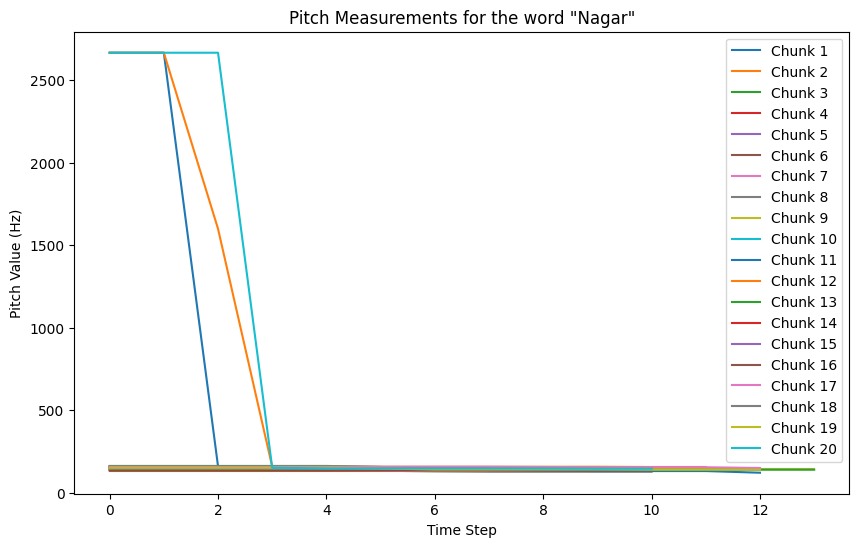

In [ ]:
plt.figure(figsize=(10, 6))
for idx, tensor_data in enumerate(pitch):
    plt.plot(tensor_data, label=f'Chunk {idx + 1}')

plt.title('Pitch Measurements for the word "Nagar"')
plt.xlabel('Time Step')
plt.ylabel('Pitch Value (Hz)')
plt.legend()
plt.show();

In [ ]:
sim_score

,audio1,audio2,sim
135,9,10,690.724652
153,10,19,659.767255
122,7,18,635.512447
6,0,7,606.671770
154,11,12,596.967524
...,...,...,...
47,2,13,195.336274
86,5,7,188.238737
137,9,12,185.486240
84,4,19,182.198397


In [ ]:
IPython.display.Audio(audio_seq[10], rate=sample_rate)

In [ ]:
IPython.display.Audio(audio_seq[19], rate=sample_rate)

### Step 4.3: Audio-based Anomaly Detection

In [ ]:
# Downloading PCA result on FFT since it runs out of RAM in Colab. The next cell was run in Kaggle and results were saved and loaded here.
!gdown --id "1s0vG6Lp9jTMPCzrquz193xSwy7qf_3Ja" -O bible/fft_all.txt

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1s0vG6Lp9jTMPCzrquz193xSwy7qf_3Ja
To: /content/bible/fft_all.txt
100% 11.4k/11.4k [00:00<00:00, 23.6MB/s]


In [ ]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])
    return xf, vals

fft_all = []
names = []
sr = 16000
full_audio_duration = []
for i in tqdm(range(len(dataset))):
    dp = dataset[i]
    samples = dp['audio']['array']
    full_audio_duration.append(len(samples)/sr)
    x, val = custom_fft(samples, sr)
    fft_all.append(val)
    names.append(dp['audio']['path'])

mini = np.inf
for fft_ in fft_all:
    mini = min(mini, len(fft_))
fft_all2 = []
for fft_ in fft_all:
    fft_all2.append(fft_[:mini])

fft_all2 = np.array(fft_all2)
fft_all2 = (fft_all2 - np.mean(fft_all2, axis=0)) / np.std(fft_all2, axis=0)

pca = PCA(n_components=3)
fft_all2 = pca.fit_transform(fft_all2)

In [ ]:
fft_all2 = []
with open(path+'fft_all.txt', 'r') as file:
    for line in file:
        array = np.fromstring(line.strip()[1:-1], sep=' ')
        fft_all2.append(array)

In [ ]:
fft_all2[0]

array([-461.26687114,  151.87930558,   33.07307418])

In [ ]:
import numpy as np
import plotly.graph_objs as go
import plotly.offline as py
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

In [ ]:
def interactive_3d_plot(data, names):
    data = np.array(data)
    scatt = go.Scatter3d(x=data[:, 0], y=data[:, 1], z=data[:, 2], mode='markers', text=names)
    plot_data = [scatt]
    layout = go.Layout(title="Anomaly detection")
    figure = go.Figure(data=plot_data, layout=layout)
    # pyo.iplot(figure)
    figure.show(renderer="colab")

interactive_3d_plot(fft_all2, paths);

After playing the audio anomalies as indicated by the plot, I couldn't find any significant difference in the audio files as of now. This would need further  investigation.

### Step 4.4: Audio Duration Analysis

Word level - Only for top 20 most frequent non-stop words

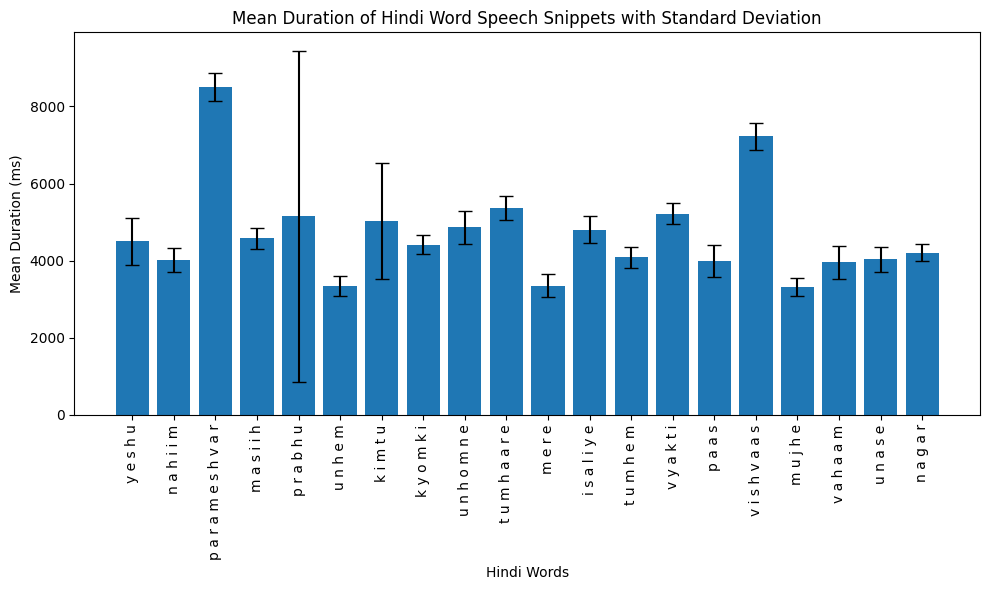

In [ ]:
words = list(word_duration.keys())
mean_durations = [word_duration[word][0] for word in words]
std_devs = [word_duration[word][1] for word in words]

# Create the plot
plt.rcParams.update(plt.rcParamsDefault)
plt.figure(figsize=(10, 6))
plt.bar(get_uroman_tokens(words,"uroman/bin/", "hi"), mean_durations, yerr=std_devs, capsize=5)
plt.xlabel('Hindi Words')
plt.ylabel('Mean Duration (ms)')
plt.title('Mean Duration of Hindi Word Speech Snippets with Standard Deviation')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout for better fit

# Show the plot
plt.show()

Audio level

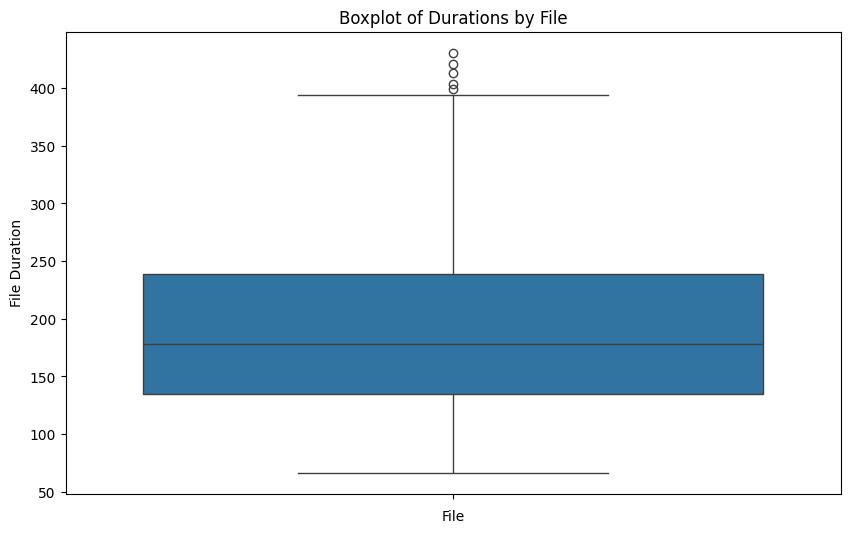

In [ ]:
words = []
for file in alignment.keys():
    for word in alignment[file]:
        if word['word_hi']!='***':
            word['file'] = file
            words.append(word)
words = pd.DataFrame(words)
words['duration'] = words['stop']-words['start']
words = words[['file', 'word_hi', 'word_en', 'duration']]
grouped_duration = words.groupby('file').sum('duration')
plt.figure(figsize=(10, 6))
sns.boxplot(grouped_duration['duration'].values)
plt.title('Boxplot of Durations by File')
plt.xlabel('File')
plt.ylabel('File Duration')
plt.show();

In [ ]:
grouped = words.groupby('file').agg({'duration': 'sum', 'word_en': 'count'})
grouped['total_chars'] = words.groupby('file')['word_en'].apply(lambda x: x.str.len().sum())

# Calculate word speed (words per second) and character speed (characters per second)
grouped['word_speed'] = grouped['word_en'] / grouped['duration']
grouped['char_speed'] = grouped['total_chars'] / grouped['duration']
print(grouped[['word_speed', 'char_speed']])

               word_speed  char_speed
file                                 
audio_1.mp3      3.392198   18.129061
audio_10.mp3     4.114438   19.997787
audio_100.mp3    3.861767   20.009419
audio_101.mp3    3.857075   19.003003
audio_102.mp3    3.890919   19.846815
...                   ...         ...
audio_95.mp3     3.601222   19.453929
audio_96.mp3     4.009049   20.402045
audio_97.mp3     3.897478   19.670022
audio_98.mp3     4.119904   20.557403
audio_99.mp3     3.974722   20.442395

[260 rows x 2 columns]


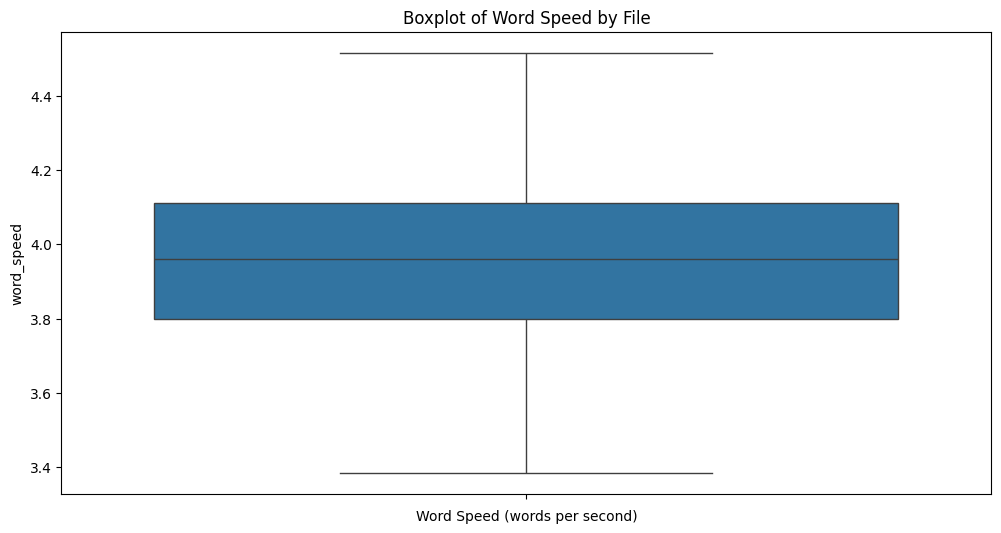

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(y=grouped['word_speed'])
plt.title('Boxplot of Word Speed by File')
plt.xlabel('Word Speed (words per second)')
plt.show();

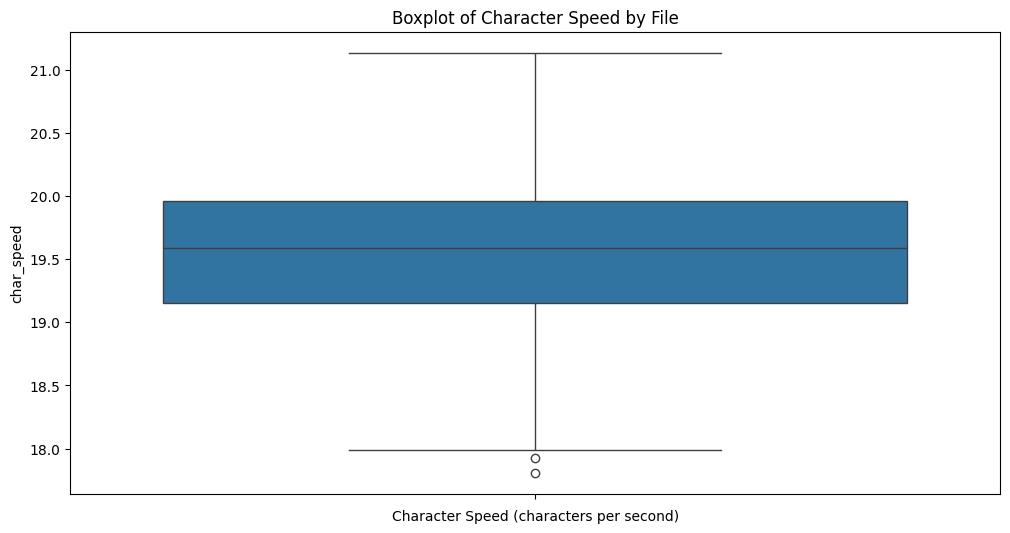

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(y=grouped['char_speed'])
plt.title('Boxplot of Character Speed by File')
plt.xlabel('Character Speed (characters per second)')
plt.show();

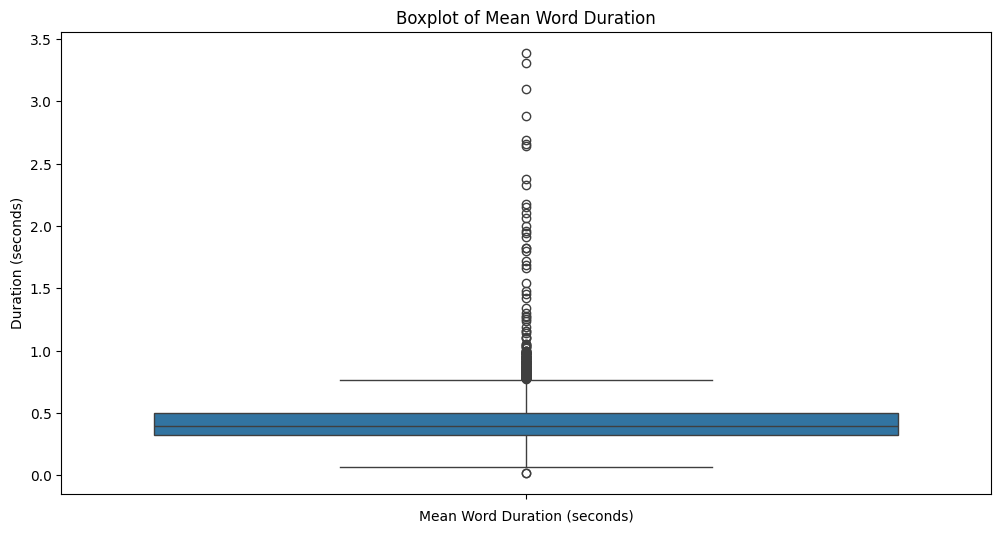

In [ ]:

plt.figure(figsize=(12, 6))
sns.boxplot(y=words.groupby('word_hi').agg({'duration':'mean'}).sort_values('duration', ascending=False)['duration'].values)
plt.title('Boxplot of Mean Word Duration')
plt.xlabel('Mean Word Duration (seconds)')
plt.ylabel('Duration (seconds)')
plt.show();

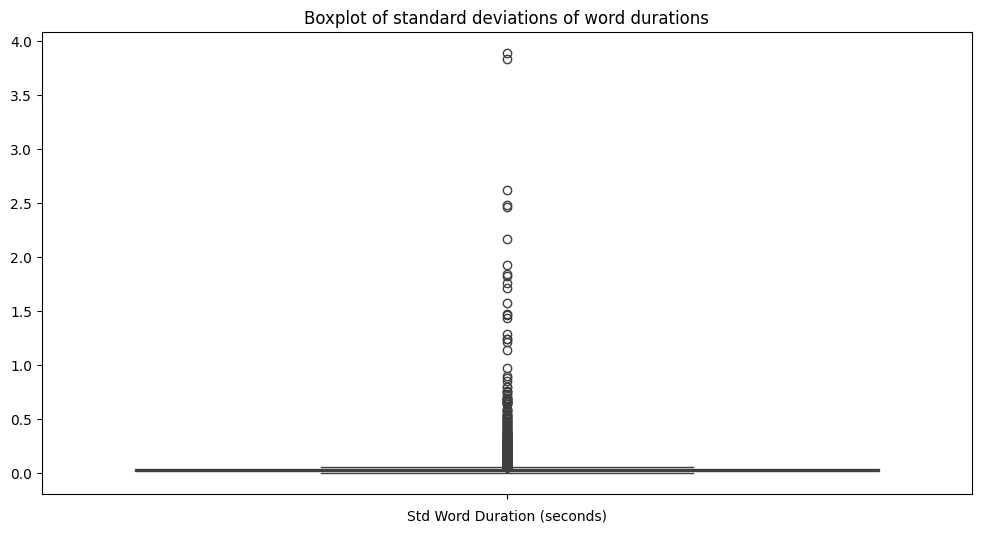

In [ ]:
array = words.groupby('word_hi').agg({'duration':'std'}).sort_values('duration', ascending=False)['duration'].values
filtered_array = array[~np.isnan(array)]

plt.figure(figsize=(12, 6))
sns.boxplot(y=filtered_array)
plt.title('Boxplot of standard deviations of word durations')
plt.xlabel('Std Word Duration (seconds)')
plt.show();

### Step 4.5: Audio Quality Analysis

In [ ]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

noise = {}
for i in tqdm(range(len(dataset))):
    noise[dataset['audio'][i]['path']] = signaltonoise(dataset['audio'][i]['array'])

### Step 4.6: Word-level Text Analysis

In [ ]:
texts = dataset['text']
sentences = []
nsen = []
stop_words = ['मैं', 'मुझको', 'मेरा', 'अपने आप को', 'हमने', 'हमारा', 'अपना', 'हम', 'आप', 'आपका', 'तुम्हारा', 'अपने आप', 'स्वयं', 'वह', 'इसे', 'उसके', 'खुद को', 'कि वह', 'उसकी', 'उसका', 'खुद ही', 'यह', 'इसके', 'उन्होने', 'अपने', 'क्या', 'जो', 'किसे', 'किसको', 'कि', 'ये', 'हूँ', 'होता है', 'रहे', 'थी', 'थे', 'होना', 'गया', 'किया जा रहा है', 'किया है', 'है', 'पडा', 'होने', 'करना', 'करता है', 'किया', 'रही', 'एक', 'लेकिन', 'अगर', 'या', 'क्यूंकि', 'जैसा', 'जब तक', 'जबकि', 'की', 'पर', 'द्वारा', 'के लिए', 'साथ', 'के बारे में', 'खिलाफ', 'बीच', 'में', 'के माध्यम से', 'दौरान', 'से पहले', 'के बाद', 'ऊपर', 'नीचे', 'को', 'से', 'तक', 'से नीचे', 'करने में', 'निकल', 'बंद', 'से अधिक', 'तहत', 'दुबारा', 'आगे', 'फिर', 'एक बार', 'यहाँ', 'वहाँ', 'कब', 'कहाँ', 'क्यों', 'कैसे', 'सारे', 'किसी', 'दोनो', 'प्रत्येक', 'ज्यादा', 'अधिकांश', 'अन्य', 'में कुछ', 'ऐसा', 'में कोई', 'मात्र', 'खुद', 'समान', 'इसलिए', 'बहुत', 'सकता', 'जायेंगे', 'जरा', 'चाहिए', 'अभी', 'और', 'कर दिया', 'रखें', 'का', 'हैं', 'इस', 'होता', 'करने', 'ने', 'बनी', 'तो', 'ही', 'हो', 'इसका', 'था', 'हुआ', 'वाले', 'बाद', 'लिए', 'सकते', 'इसमें', 'दो', 'वे', 'करते', 'कहा', 'वर्ग', 'कई', 'करें', 'होती', 'अपनी', 'उनके', 'यदि', 'हुई', 'जा', 'कहते', 'जब', 'होते', 'कोई', 'हुए', 'व', 'जैसे', 'सभी', 'करता', 'उनकी', 'तरह', 'उस', 'आदि', 'इसकी', 'उनका', 'इसी', 'पे', 'तथा', 'भी', 'परंतु', 'इन', 'कम', 'दूर', 'पूरे', 'गये', 'तुम', 'मै', 'यहां', 'हुये', 'कभी', 'अथवा', 'गयी', 'प्रति', 'जाता', 'इन्हें', 'गई', 'अब', 'जिसमें', 'लिया', 'बड़ा', 'जाती', 'तब', 'उसे', 'जाते', 'लेकर', 'बड़े', 'दूसरे', 'जाने', 'बाहर', 'स्थान', 'उन्हें ', 'गए', 'ऐसे', 'जिससे', 'समय', 'दोनों', 'किए', 'रहती', 'इनके', 'इनका', 'इनकी', 'सकती', 'आज', 'कल', 'जिन्हें', 'जिन्हों', 'तिन्हें', 'तिन्हों', 'किन्हों', 'किन्हें', 'इत्यादि', 'इन्हों', 'उन्हों', 'बिलकुल', 'निहायत', 'इन्हीं', 'उन्हीं', 'जितना', 'दूसरा', 'कितना', 'साबुत', 'वग़ैरह', 'कौनसा', 'लिये', 'दिया', 'जिसे', 'तिसे', 'काफ़ी', 'पहले', 'बाला', 'मानो', 'अंदर', 'भीतर', 'पूरा', 'सारा', 'उनको', 'वहीं', 'जहाँ', 'जीधर', 'के', 'एवं', 'कुछ', 'कुल', 'रहा', 'जिस', 'जिन', 'तिस', 'तिन', 'कौन', 'किस', 'संग', 'यही', 'बही', 'उसी', 'मगर', 'कर', 'मे', 'एस', 'उन', 'सो', 'अत', 'हूं', 'न']
nwords = []
for t in texts:
    temp = t.split("\n")
    nsen.append(len(temp))
    nwords.append(np.sum([len(sent.split()) for sent in temp]))
    sentences.extend(temp)
sentences = [text_normalize(line.strip(), "hi") for line in sentences]
words = []
for s in sentences:
    words.extend(s.split())

print("Total number of words: ", str(len(words)))
print("Total number of characters: ", str(len(" ".join(words))))
print("Vocab Size: ", str(len(np.unique(words))))
print("Mean sentences per audio file: ", str(np.mean(nsen)))
print("Mean words per audio file: ", str(np.mean(nwords)))

Total number of words:  198863
Total number of characters:  952549
Vocab Size:  7348
Mean sentences per audio file:  30.588461538461537
Mean words per audio file:  760.5538461538462


In [ ]:
filter_words = []
for w in words:
    if w not in stop_words:
        filter_words.append(w)
print("Top 10 highest repeating words: \n")
pd.Series(filter_words).value_counts().head(10)

Top 10 highest repeating words: 



येशु        1948
नहीं        1818
परमेश्वर    1589
मसीह        1402
प्रभु       1098
उन्हें       813
किंतु        761
क्योंकि      724
उन्होंने     716
तुम्हारे     662
Name: count, dtype: int64

In [ ]:
new_texts = []
for t in texts:
    new_texts.append(text_normalize(texts[0].replace('\n', ' '), "hi"))

tokenized = []
for t in new_texts:
    tokenized.extend(word_tokenize(t))

def generate_non_overlapping_ngrams(words, n):
    return [" ".join(words[i:i+n]) for i in range(0, len(words), n) if len(words[i:i+n]) == n]


gram3 = generate_non_overlapping_ngrams(tokenized, 3)
gram4 = generate_non_overlapping_ngrams(tokenized, 4)

gram3_counts = Counter(gram3)
gram4_counts = Counter(gram4)

print("Most common 3-grams:", gram3_counts.most_common(5))
print("Most common 4-grams:", gram4_counts.most_common(5))

Most common 3-grams: [('दावीद के वंशज', 174), ('भाई उत्पन्न हुए', 174), ('बाबेल पहुंचने के', 174), ('पुत्र को जन्म', 174), ('से बाबेल पहुंचने', 173)]
Most common 4-grams: [('अब्राहाम की संतान दावीद', 260), ('के वंशज येशु मसीह', 260), ('की वंशावली अब्राहाम से', 260), ('यित्सहाक यित्सहाक से याकोब', 260), ('याकोब से यहूदाह तथा', 260)]


### Step 4.7: Text Bias Analysis

Since the scraped data is from one source only, it is important to perform bias analysis in our dataset for generalizability evaluation. To identify biased words, I compare token frequency of word from a general purpose hindi corpus. If token frequency of word is more than double the token frequency from a general purpose corpus then word seems to be biased.

In [ ]:
#OSCAR small dataset
cc_hi = load_dataset("nthngdy/oscar-small", language="hi")
cc_hi = cc_hi['train']['text']
cc_texts = []
for t in tqdm(cc_hi):
    temp = text_normalize(t.replace('\n', ' '), "hi")
    temp = temp.split()
    cc_texts.extend(temp)

cc_vc = dict(pd.Series(cc_texts).value_counts())
current_vc = dict(pd.Series(tokenized).value_counts())
cc_sum = sum(list(cc_vc.values()))
current_sum = sum(list(current_vc.values()))

subset = []
for key in list(current_vc.keys()):
    if key in stop_words:
        continue
    try:
        if(current_vc[key]/current_sum < 2*cc_vc[key]/cc_sum):
            continue
    except:
        pass
    subset.append(key)
print(subset[:10])

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1491: FutureWarning:

The repository for nthngdy/oscar-small contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/nthngdy/oscar-small
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.



Generating train split: 0 examples [00:00, ? examples/s]

100%|██████████| 246567/246567 [00:55<00:00, 4475.09it/s]


['उत्पन्न', 'मरियम', 'दावीद', 'येशु', 'योसेफ़', 'पुत्र', 'उन्होंने', 'जन्म', 'मसीह', 'बाबेल']


The above subset was then keyed into GPT-4 for categorization into names, verbs, nouns, etc.

In [ ]:
bias_analysis = {
    "Names": ['मरियम', 'दावीद', 'येशु', 'योसेफ़', 'मसीह', 'याकोब', 'अब्राहाम', 'यहूदाह', 'इम्मानुएल',
              'उज्जियाह', 'योथाम', 'आख़ाज़', 'हेज़ेकिया', 'मनश्शेह', 'अमोन', 'योशियाह', 'यख़ोनिया',
              'सलाथिएल', 'ज़ेरोबाबेल', 'अबिहूद', 'एलियाकिम', 'आज़ोर', 'सादोक', 'आख़िम', 'एलिहूद',
              'एलियाज़र', 'मत्थान', 'शलोमोन', 'रोबोआम', 'हबीया', 'आसफ', 'यहोशाफ़ात', 'योराम', 'सलमोन',
              'बोअज़', 'ओबेद', 'यिशै', 'फ़ारेस', 'हेज़रोन', 'हाराम', 'अम्मीनादाब', 'नाहश्शोन', 'यित्सहाक',
              'तामार', 'राहाब', 'रूथ', 'उरियाह', 'ज़ारा', 'प्रभु', 'परमेश्वर'],
    "Verbs": ['उत्पन्न', 'पहुंचने', 'रखा', 'देगी', 'पुकारेगी', 'चुका', 'मालूम', 'गर्भवती', 'तय',
              'चाहते', 'हुईं', 'पड़े', 'त्याग', 'देने', 'निर्णय', 'निश्चय', 'जागने', 'रखना', 'स्वीकार',
              'देगी', 'करेगी', 'देंगे'],
    "Nouns": ['जन्म', 'पुत्र', 'पत्नी', 'नाम', 'भाई', 'वंशज', 'स्वर्गदूत', 'विवाह', 'पीढ़ियां',
              'प्रकार', 'गर्भ', 'संतान', 'कुंवारी', 'कन्या', 'गर्भधारण', 'पापों', 'उद्धार', 'सब',
              'भविष्यवक्ता', 'माध्यम', 'वचन', 'अर्थ', 'हमारे', 'वंशावली'],
    "Adjectives": ['पवित्र', 'धर्मी', 'पवित्रात्मा', 'सुरक्षित', 'धर्मी'],
    "Others": ['उन्होंने', 'क्यों', 'किंतु', 'क्योंकि', 'इससे', 'उनके', 'जिनके', 'जिनमें', 'उससे',
               'उनपर', 'मत', 'इसलिये', 'वैसा']
}

From the above, it can be seen that most names are from christianity due to the source of the dataset, hence it is important to include a diversity of religious data sources to prevent the model to be biased to a certain religion.

### Step 4.8: Phoneme-Level Analysis

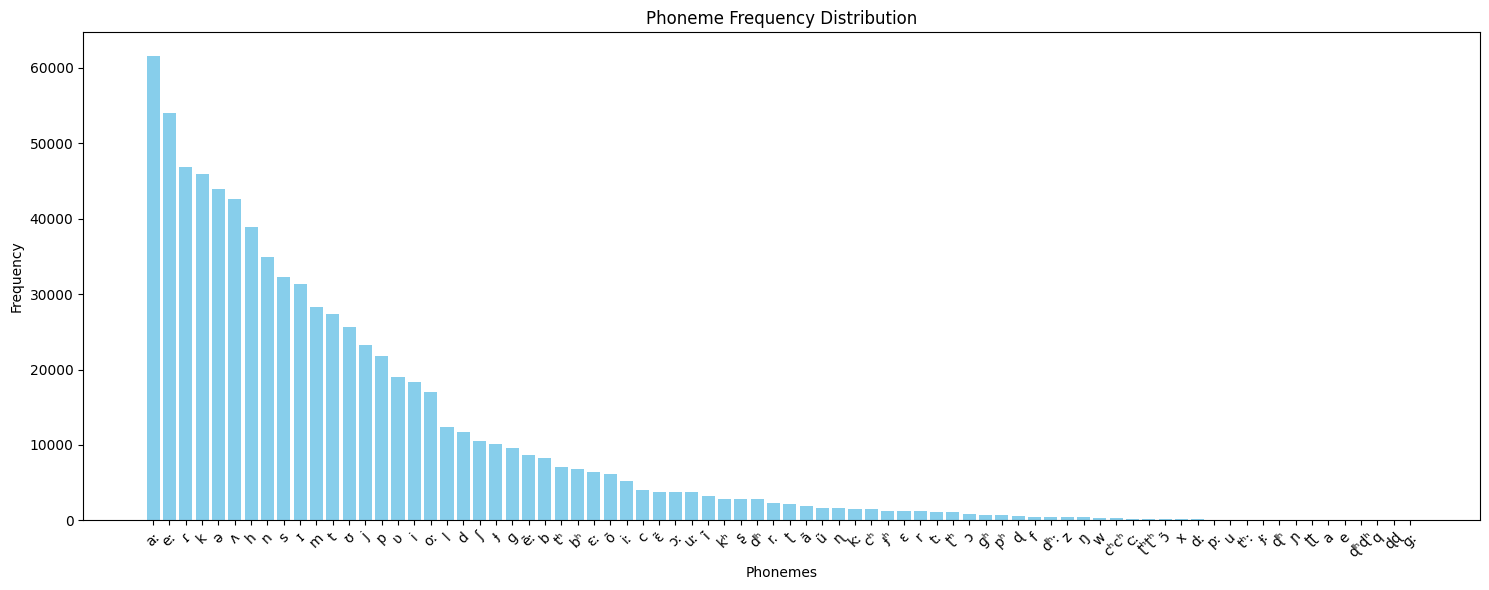

In [ ]:
hindi_words = []
for keys in list(alignment.keys()):
    for word in alignment[keys]:
        if word['word_en']!="***":
            hindi_words.append(word['word_hi'])

def phonemize_text(text_list):
    backend = EspeakBackend(language='hi', punctuation_marks=';.', preserve_punctuation=False)
    separator = Separator(phone=',', word='')
    phonemes = backend.phonemize(text_list, separator=separator)
    return phonemes

phonemes = phonemize_text(hindi_words)

phoneme_list = ' '.join(phonemes).split(',')
phoneme_list = [pho.strip() for pho in phoneme_list if pho!='']
phoneme_freq = Counter(phoneme_list)

df_phoneme = pd.DataFrame(list(phoneme_freq.items()), columns=['Phoneme', 'Frequency'])
df_phoneme = df_phoneme.sort_values('Frequency', ascending=False)

plt.figure(figsize=(15, 6))
plt.bar(df_phoneme['Phoneme'], df_phoneme['Frequency'], color='skyblue')
plt.xlabel('Phonemes')
plt.ylabel('Frequency')
plt.title('Phoneme Frequency Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show();

In [ ]:
print(df_phoneme[-20:])

   Phoneme  Frequency
67       w        356
68    cʰcʰ        283
63      cː        215
66    ʈʰʈʰ        176
62      ɔ̃        149
33       x        137
58      dː        136
57      pː        123
65       u        105
37     tʰː         97
32      ɟː         77
70      ɖʰ         73
73       ɲ         68
69      ʈʈ         53
72       a         53
71       e         39
75    ɖʰɖʰ         18
74       q         12
76      ɖɖ          6
77      ɡː          2


Phonemes with low frequency need to be included in the corpus for a better general purpose WER and CER

In [ ]:
gram3 = generate_non_overlapping_ngrams(phoneme_list, 3)
gram4 = generate_non_overlapping_ngrams(phoneme_list, 4)
gram5 = generate_non_overlapping_ngrams(phoneme_list, 5)
gram6 = generate_non_overlapping_ngrams(phoneme_list, 6)

gram3_counts = Counter(gram3)
gram4_counts = Counter(gram4)
gram5_counts = Counter(gram5)
gram6_counts = Counter(gram6)

print("Least common 3-grams:", gram3_counts.most_common()[-5:])
print("Least common 4-grams:", gram4_counts.most_common()[-5:])
print("Least common 5-grams:", gram5_counts.most_common()[-5:])
print("Least common 6-grams:", gram6_counts.most_common()[-5:])

Least common 3-grams: [('ã ɪ s', 1), ('aː ʈʰ p', 1), ('ɾ pʰ ʊ', 1), ('b p eː', 1), ('ẽː p eː', 1)]
Least common 4-grams: [('eː k ɪ ɡ', 1), ('aː ʊ t ɾ', 1), ('ẽː bʰ aː ʂ', 1), ('ʈʰ aː s ʌ', 1), ('m aː l ẽː', 1)]
Least common 5-grams: [('h õ n eː ʈʰ', 1), ('iː k h ə m', 1), ('l ẽː p eː t', 1), ('eː k ʊ cʰ d', 1), ('ɪ n ɔː ɾ ʌ', 1)]
Least common 6-grams: [('ʈʰ iː k h ə m', 1), ('aː ɾ eː h i s', 1), ('ɛː t ʌ b p eː', 1), ('m aː l ẽː p eː', 1), ('ə n eː k i ʋ', 1)]


Phoneme sequences with low frequency should be added to the dataset

## Step 5: Conclusion 📄

To use this dataset for STT and TTS applications, different post processing mechanisms are required since TTS datasets focus on high-quality, clear audio recordings whereas STT datasets may include a variety of audio qualities, background noises, and different speaking styles to make the model robust.

To use this dataset for TTS, prosodic annotations could be added as required to indicate pitch, stress, pause, emphasis & other emotions.

For STT, a more diverse range of audio data including noisy and challenging conditions, different dialects, different age groups & genders should be included to make model more robust. Currently, it seems that there is just one male speaker with one dialect in all recordings.


Key Data Insights:
- First few seconds of almost all audio files are not transcribed. These should be excluded to improve performance.
- Many words are transcribed incorrectly in the dataset. It would be worthwhile to run a commercial ASR on the text and compare it with transcriptions to correct errors.
- Words with low DTW/high similarity in pitch and general audio indicate that more variants of those words should be added to dataset for improved performance.
- There is high standard deviation for word audio duration. This is partly also because of transcription, alignment errors too.
- Audio quality seems to be good with low noise levels.
- It is recommended to combine this dataset with texts from other religion to make the proabilities of next token predicition bias free from any specific religion.
- Phoneme analysis indicates many individual phonemes and phoneme sequences with low frequency. Sentences with these phonemes and phoneme sequences should be added to the dataset to reduce errors on these low-occuring phonemes.

# 🙏🙏🙏   Thank you --- धन्यवाद --- நன்றி   🙏🙏🙏​